In [2]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
import warnings

warnings.filterwarnings("ignore", message="Could not infer format, so each element")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
cores = '14'

PICKLE_BASE_DIR = f"../data/MAR2_al/MAR2_prbs_random/{cores}"
DATA_DIR        = f"../results/{cores}/"

OUT_G           = f"../results/{cores}/G_matrix.csv"
OUT_C           = f"../results/{cores}/C_vector.csv"
OUT_b           = f"../results/{cores}/b_vector.csv"

# Number of DVFS states to detect via clustering
DVFS_STATES     = 3
# Regression settings
DELTA_SHIFT     = 1  # predict 1 step (0.5 s) ahead
ALPHA           = 1.0
# Placeholders for estimated idle/peak power
IDLE_POWER      = None
ASSUMED_PMAX    = None

In [5]:
# ─── UTILITY FUNCTIONS ───────────────────────────────────────────────────────
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def ensure_dirs():
    os.makedirs(DATA_DIR, exist_ok=True)

# ─── CHARACTERIZE Pij & fij FROM DATA ─────────────────────────────────────────
def characterize_freq_states(pickle_base_dir, max_states=6):
    """
    1) Concatenate all cores’ util, power, perf across rounds.
    2) Automatically pick dvfs_states ∈ [2..max_states] maximizing total silhouette.
    3) Cluster each core’s util into dvfs_states groups.
    4) Compute P_FREQ and FREQ_PERF per core×state.
    5) Plot example clusterings for first 3 cores.
    Returns:
      P_FREQ, FREQ_PERF, dvfs_states
    """
    # 1) Load & concat
    util_list, power_list, perf_list = [], [], []
    pattern = os.path.join(pickle_base_dir, "round*", "preprocessing", "round*.pkl")
    for pkl_path in sorted(glob.glob(pattern)):
        pkl = load_pickle(pkl_path)
        # utilization ratio
        util_df = pkl["freq_aperf_mperf_core"].astype(float)
        util_df.index = pd.to_timedelta(util_df.index.astype(float), unit="s")
        power_df = compute_power_proxy(pkl)
        perf_df  = pkl["aperf_core"].astype(float)
        perf_df.index = util_df.index

        util_list.append(util_df)
        power_list.append(power_df)
        perf_list.append(perf_df)

    util_all  = pd.concat(util_list)
    power_all = pd.concat(power_list)
    perf_all  = pd.concat(perf_list)
    interval  = (util_all.index[1] - util_all.index[0]).total_seconds()
    N = util_all.shape[1]

    # 2) Pick best k via silhouette
    best_k, best_score = 2, -np.inf
    for k in range(2, max_states+1):
        total_sil = 0.0
        for i in range(N):
            u = util_all.iloc[:, i].values.reshape(-1,1)
            labels = KMeans(n_clusters=k, random_state=0).fit_predict(u)
            total_sil += silhouette_score(u, labels)
        if total_sil > best_score:
            best_k, best_score = k, total_sil

    dvfs_states = best_k

    print(f'The best number of states is {dvfs_states}.')

    # 3) Cluster per core into dvfs_states
    P_FREQ, FREQ_PERF = {}, {}
    for i in range(N):
        u       = util_all.iloc[:, i].values.reshape(-1,1)
        km      = KMeans(n_clusters=dvfs_states, random_state=0).fit(u)
        labels  = km.labels_
        centers = km.cluster_centers_.flatten()
        order   = np.argsort(centers)
        mapping = {lab: state for state, lab in enumerate(order)}

        P_FREQ[i], FREQ_PERF[i] = {}, {}
        for lab, state in mapping.items():
            mask = labels == lab
            P_FREQ[i][state]    = float(power_all.iloc[:, i][mask].mean())
            FREQ_PERF[i][state] = float(perf_all.iloc[:, i][mask].mean() / interval)

    # 4) Visualize clusters for a few cores
    for i in range(min(3, N)):
        u = util_all.iloc[:, i].values
        km = KMeans(n_clusters=dvfs_states, random_state=0).fit(u.reshape(-1,1))
        labels = km.labels_
        centers = np.sort(km.cluster_centers_.flatten())

        plt.figure(figsize=(8,2))
        for state in range(dvfs_states):
            idxs = np.where(labels == state)[0]
            plt.scatter(idxs, u[idxs], s=5, label=f"state {state}")
        for c in centers:
            plt.axhline(c, color="k", linestyle="--", alpha=0.7)
        plt.title(f"Core {i} utilization clusters (k={dvfs_states})")
        plt.xlabel("Sample index")
        plt.ylabel("Utilization")
        plt.legend(loc="upper right", fontsize="small")
        plt.tight_layout()
        plt.show()

    return P_FREQ, FREQ_PERF, dvfs_states
# ─── WRITE CHARACTERIZATION CSVs ───────────────────────────────────────────────
def write_power_map(p_freq, out_file=DATA_DIR+"Pij.csv"):
    df = pd.DataFrame(p_freq).T
    df.index.name = "core"
    df.columns.name = "freq"
    df.to_csv(out_file)
    print(f"[char] wrote power map to {out_file}")

def write_perf_map(freq_perf, out_file=DATA_DIR+"fij.csv"):
    df = pd.DataFrame(freq_perf).T
    df.index.name = "core"
    df.columns.name = "freq"
    df.to_csv(out_file)
    print(f"[char] wrote perf map to {out_file}")

def write_Tprev(data_dir, out_file=DATA_DIR+"Tprev_vec.csv"):
    files = sorted(glob.glob(os.path.join(data_dir, "round*_combined.csv")))
    if not files:
        print("[char] No combined CSVs found for Tprev extraction.")
        return
    df = pd.read_csv(files[-1], index_col=0)
    temp_cols = [c for c in df.columns if c.startswith("T_core_")]
    last = df[temp_cols].iloc[-1]
    pd.Series(last.values).to_csv(out_file, index=False, header=False)
    print(f"[char] wrote Tprev vector to {out_file}")

# ─── POWER PROXY & TIMESERIES PREP ─────────────────────────────────────────────
def estimate_idle_and_pmax(pickle_base_dir, pct=(0.05,0.95)):
    per_core_pw = []
    n_cores = None
    pattern = os.path.join(pickle_base_dir, "round*", "preprocessing", "round*.pkl")
    for pkl_path in sorted(glob.glob(pattern)):
        pkl = load_pickle(pkl_path)
        pkg = pkl.get("power_from_erg_pkg_cpu")
        if pkg is None:
            continue
        pkg = pkg.astype(float)
        if n_cores is None:
            n_cores = pkl.get("temp_core").shape[1]
        avg_core = pkg.sum(axis=1) / n_cores
        per_core_pw.append(avg_core)
    all_pw = pd.concat(per_core_pw)
    idle, peak = all_pw.quantile(pct).values
    return float(idle), float(peak)

def compute_power_proxy(pkl):
    util = pkl["freq_aperf_mperf_core"].astype(float)
    return IDLE_POWER + (ASSUMED_PMAX - IDLE_POWER) * util

def ensure_timedelta_index(df):
    if not isinstance(df.index, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        df = df.copy()
        df.index = pd.to_timedelta(df.index.astype(float), unit="s")
    return df

def resample_df(df, freq="500ms"):
    df = ensure_timedelta_index(df)
    return df.resample(freq).mean().interpolate()

def process_round_to_csv(pkl_path):
    pkl   = load_pickle(pkl_path)
    temp  = pkl["temp_core"]
    power = compute_power_proxy(pkl)
    t_rs  = resample_df(temp)
    p_rs  = resample_df(power)
    t_rs.columns = [f"T_core_{c}" for c in t_rs.columns]
    p_rs.columns = [f"P_core_{c}" for c in p_rs.columns]
    df    = pd.concat([p_rs, t_rs], axis=1)
    rnd   = os.path.basename(os.path.dirname(os.path.dirname(pkl_path)))
    out   = os.path.join(DATA_DIR, f"{rnd}_combined.csv")
    df.to_csv(out, index_label="time_s")
    print(f"[prep] wrote {out}")

def prepare_combined_csvs():
    pattern = os.path.join(PICKLE_BASE_DIR, "round*", "preprocessing", "round*.pkl")
    for pkl_path in sorted(glob.glob(pattern)):
        rnd  = os.path.basename(os.path.dirname(os.path.dirname(pkl_path)))
        csvp = os.path.join(DATA_DIR, f"{rnd}_combined.csv")
        if not os.path.exists(csvp):
            process_round_to_csv(pkl_path)

In [6]:
def load_all_csvs():
    files = sorted(glob.glob(os.path.join(DATA_DIR, "round*_combined.csv")))
    dfs   = []
    for fpath in files:
        df = pd.read_csv(fpath, index_col=0)
        # parse index strings as Timedelta
        df.index = pd.to_timedelta(df.index)
        dfs.append(df)
    return pd.concat(dfs)

def fit_core(df, core_idx, delta=1, alpha=1.0):
    P_cols = [c for c in df.columns if c.startswith("P_core_")]
    T_col  = f"T_core_{core_idx}"
    X      = df[P_cols].copy()
    X[T_col] = df[T_col]
    y       = df[T_col].shift(-delta)
    valid   = y.notna()
    X_train = X.loc[valid]
    y_train = y.loc[valid]
    X_train = X_train.loc[:, X_train.var() > 0]
    model   = Ridge(alpha=alpha, fit_intercept=True).fit(X_train, y_train)
    full    = np.zeros(len(P_cols)+1)
    kept    = list(X_train.columns)
    for coef, name in zip(model.coef_, kept):
        idx = P_cols.index(name) if name in P_cols else len(P_cols)
        full[idx] = coef
    return full[:len(P_cols)], full[len(P_cols)], model.intercept_

def fit_and_save():
    df = load_all_csvs()
    N  = len([c for c in df if c.startswith("P_core_")])
    G  = np.zeros((N, N)); C = np.zeros(N); b = np.zeros(N)
    for ell in range(N):
        G_l, C_l, b_l = fit_core(df, ell, DELTA_SHIFT, ALPHA)
        G[ell,:], C[ell], b[ell] = G_l, C_l, b_l
        print(f"[fit] core {ell}: C={C_l:.4f}, b={b_l:.4f}")
    pd.DataFrame(G).to_csv(OUT_G, index=False)
    pd.Series(C).to_csv(OUT_C, index=False)
    pd.Series(b).to_csv(OUT_b, index=False)
    print(f"[fit] wrote {OUT_G}, {OUT_C}, {OUT_b}")

Estimated idle: 2.51 W, peak: 2.83 W
The best number of states is 2.


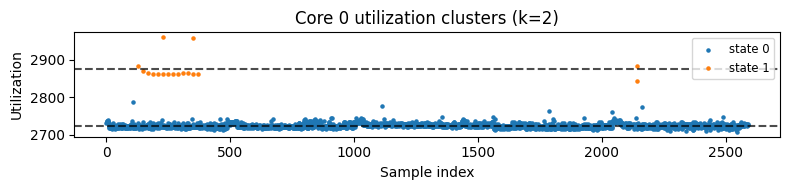

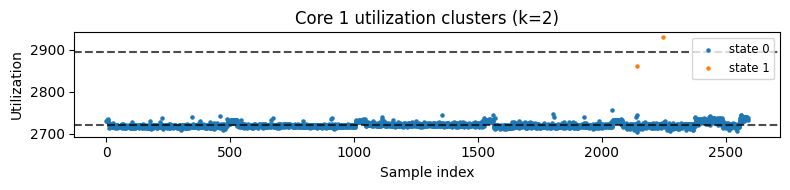

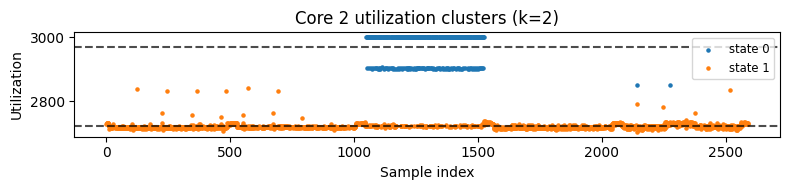

[char] wrote power map to ../results/14/Pij.csv
[char] wrote perf map to ../results/14/fij.csv
[char] wrote Tprev vector to ../results/14/Tprev_vec.csv
[fit] core 0: C=0.7355, b=34.3821
[fit] core 1: C=0.7220, b=63.8480
[fit] core 2: C=0.6312, b=75.1672
[fit] core 3: C=0.7108, b=40.3571
[fit] core 4: C=0.5342, b=281.0337
[fit] core 5: C=0.6018, b=103.4587
[fit] core 6: C=0.7336, b=30.5207
[fit] core 7: C=0.7107, b=73.2134
[fit] core 8: C=0.6383, b=182.4365
[fit] core 9: C=0.6498, b=56.2087
[fit] core 10: C=0.7037, b=45.7806
[fit] core 11: C=0.7263, b=25.4633
[fit] core 12: C=0.6201, b=162.4883
[fit] core 13: C=0.6323, b=93.0927
[fit] core 14: C=0.7064, b=63.2315
[fit] core 15: C=0.6811, b=97.7325
[fit] core 16: C=0.7270, b=36.9331
[fit] core 17: C=0.6924, b=65.8799
[fit] core 18: C=0.6517, b=105.4098
[fit] core 19: C=0.6639, b=44.9925
[fit] core 20: C=0.7400, b=58.6945
[fit] core 21: C=0.6654, b=26.3938
[fit] core 22: C=0.7733, b=34.2232
[fit] core 23: C=0.6885, b=33.4614
[fit] core 24

In [8]:
if __name__ == "__main__":
    
    ensure_dirs()
    # estimate idle/peak power
    idle, peak = estimate_idle_and_pmax(PICKLE_BASE_DIR)
    print(f"Estimated idle: {idle:.2f} W, peak: {peak:.2f} W")
    IDLE_POWER, ASSUMED_PMAX = idle, peak
    
    # auto-populate Pij and fij
    if DVFS_STATES > 0:
        P_FREQ, FREQ_PERF, states = characterize_freq_states(PICKLE_BASE_DIR, DVFS_STATES)
        write_power_map(P_FREQ)
        write_perf_map(FREQ_PERF)
    
    # prepare combined timeseries
    prepare_combined_csvs()
    # extract last temperatures
    write_Tprev(DATA_DIR)
    # fit thermal model
    fit_and_save()